In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

class TwoStageContractPredictor:
    """
    A two-stage model to predict contract signing while handling temporal leakage
    and class imbalance.
    
    Stage 1: Predicts likelihood of getting to sales call stage
    Stage 2: Predicts contract signing given sales call occurred
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler()
        self.stage1_features = None
        self.stage2_features = None
        
    def identify_feature_stages(self, df):
        """
        Categorize features by their temporal stage to prevent leakage
        """
        # Stage 1 features: Available before any sales call
        stage1_features = [
            # Initial lead characteristics
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            
            # Marketing and region features
            'mktg_High', 'mktg_Low', 'mktg_Medium',
            'region_High_Performer', 'region_Large_Good', 
            'region_Medium', 'region_Other',
            
            # BC (Business Call) features - these happen before SC
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]
        
        # Stage 2 features: Include SC-related features
        # Only use these when predicting among those who had SC
        stage2_features = stage1_features + [
            'gross_FU', 'gross_SC', 'net_FU', 'net_SC',
            'time_first_sc_to_first_net_fu'
        ]
        
        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]
        
        return self.stage1_features, self.stage2_features
    
    def create_stage_labels(self, df):
        """
        Create labels for each stage
        """
        # Stage 1: Did they get to a meaningful SC stage?
        # Using net_SC > 0 as proxy for meaningful SC engagement
        stage1_label = (df['net_SC'] > 0).astype(int)
        
        # Stage 2: Among those with SC, did they sign?
        stage2_label = df['grosscontractsigned']
        
        return stage1_label, stage2_label
    
    def build_neural_network(self, input_dim, name="model"):
        """
        Build a neural network with dropout for regularization
        """
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu', name=f'{name}_hidden1'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu', name=f'{name}_hidden2'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu', name=f'{name}_hidden3'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid', name=f'{name}_output')
        ], name=name)
        
        return model
    
    def handle_imbalance(self, X, y, strategy='hybrid'):
        """
        Handle class imbalance using various strategies
        """
        if strategy == 'smote':
            # Pure SMOTE
            smote = SMOTE(random_state=self.random_state)
            X_res, y_res = smote.fit_resample(X, y)
            
        elif strategy == 'undersample':
            # Pure undersampling
            rus = RandomUnderSampler(random_state=self.random_state)
            X_res, y_res = rus.fit_resample(X, y)
            
        elif strategy == 'hybrid':
            unique, counts = np.unique(y, return_counts=True)
            if len(counts) < 2:
                # Only one class present, no resampling needed
                X_res, y_res = X, y
            else:
                minority_count = min(counts)
                majority_count = max(counts)
                current_ratio = minority_count / majority_count
                
                # Use conservative ratios that won't conflict
                smote_ratio = min(0.3, current_ratio * 3)  # Don't oversample too much
                final_ratio = min(0.6, current_ratio * 5)   # Final balanced ratio
                
                try:
                    pipeline = ImbPipeline([
                        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=self.random_state)),
                        ('undersample', RandomUnderSampler(sampling_strategy=final_ratio, random_state=self.random_state))
                    ])
                    X_res, y_res = pipeline.fit_resample(X, y)
                except ValueError:
                    # If hybrid fails, fall back to SMOTE only
                    print("Hybrid strategy failed, using SMOTE only")
                    smote = SMOTE(sampling_strategy=min(0.3, current_ratio * 2), random_state=self.random_state)
                    X_res, y_res = smote.fit_resample(X, y)
            return X_res, y_res 
        
    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        """
        Train Stage 1: Predict SC engagement
        """
        print("Training Stage 1: Predicting Sales Call Engagement...")
        print(f"Class distribution - 0: {sum(y_train==0)}, 1: {sum(y_train==1)}")
        
        # Handle imbalance
      #  X_train_balanced, y_train_balanced = self.handle_imbalance(
        #    X_train, y_train, strategy='hybrid'
       # )
       # print(f"After balancing - 0: {sum(y_train_balanced==0)}, 1: {sum(y_train_balanced==1)}")
# for now no imbalance handling
        X_train_balanced, y_train_balanced =  X_train, y_train
        
        # Scale features
        X_train_scaled = self.stage1_scaler.fit_transform(X_train_balanced)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        
        # Build and compile model
        self.stage1_model = self.build_neural_network(
            X_train_scaled.shape[1], name="stage1"
        )
        
        # Use class weights for additional imbalance handling
        class_weight = {0: 1., 1: 3.}  # Adjust based on your needs
        
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        
        # Early stopping callback
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_auc', patience=10, restore_best_weights=True, mode='max'
        )
        
        # Train
        history = self.stage1_model.fit(
            X_train_scaled, y_train_balanced,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Evaluate
        val_pred = self.stage1_model.predict(X_val_scaled).ravel()
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"Stage 1 Validation AUC: {val_auc:.4f}")
        
        return history
    
    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        """
        Train Stage 2: Predict contract signing given SC occurred
        """
        print("\nTraining Stage 2: Predicting Contract Signing (given SC)...")
        print(f"Class distribution - 0: {sum(y_train==0)}, 1: {sum(y_train==1)}")
        
        # Handle imbalance (likely less severe here)
       # X_train_balanced, y_train_balanced = self.handle_imbalance(
    #        X_train, y_train, strategy='smote'
      #  )
      #  print(f"After balancing - 0: {sum(y_train_balanced==0)}, 1: {sum(y_train_balanced==1)}")

      # for now no imbalance handling
        X_train_balanced, y_train_balanced =  X_train, y_train
        
        # Scale features
        X_train_scaled = self.stage2_scaler.fit_transform(X_train_balanced)
        X_val_scaled = self.stage2_scaler.transform(X_val)
        
        # Build and compile model
        self.stage2_model = self.build_neural_network(
            X_train_scaled.shape[1], name="stage2"
        )
        
        self.stage2_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        
        # Early stopping
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_auc', patience=10, restore_best_weights=True, mode='max'
        )
        
        # Train
        history = self.stage2_model.fit(
            X_train_scaled, y_train_balanced,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Evaluate
        val_pred = self.stage2_model.predict(X_val_scaled).ravel()
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"Stage 2 Validation AUC: {val_auc:.4f}")
        
        return history
    
    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        """
        Train the complete two-stage model
        """
        # Identify features for each stage
        self.identify_feature_stages(df)
        
        # Create stage labels
        stage1_label, stage2_label = self.create_stage_labels(df)
        
        # Split data
        X_stage1 = df[self.stage1_features]
        X_stage2 = df[self.stage2_features]
        
        # Train-test split for Stage 1
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2, 
            random_state=self.random_state, stratify=stage1_label
        )
        
        # Train Stage 1
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)
        
        # For Stage 2, only use samples that had SC engagement
        stage2_mask = stage1_label == 1
        X_stage2_filtered = X_stage2[stage2_mask]
        y_stage2_filtered = stage2_label[stage2_mask]
        
        # Train-test split for Stage 2
        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        
        # Train Stage 2
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)
        
    def predict_proba(self, df):
        """
        Make predictions using the two-stage model
        """
        # Stage 1: Probability of SC engagement
        X_stage1 = df[self.stage1_features]
        X_stage1_scaled = self.stage1_scaler.transform(X_stage1)
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()
        
        # Stage 2: Probability of contract given SC
        X_stage2 = df[self.stage2_features]
        X_stage2_scaled = self.stage2_scaler.transform(X_stage2)
        p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        
        # Combined probability: P(contract) = P(SC) * P(contract|SC)
        p_contract = p_sc * p_contract_given_sc
        
        return {
            'p_sc': p_sc,
            'p_contract_given_sc': p_contract_given_sc,
            'p_contract': p_contract
        }
    
    def evaluate(self, df):
        """
        Evaluate the model performance
        """
        predictions = self.predict_proba(df)
        y_true = df['grosscontractsigned']
        
        # Calculate metrics
        auc_score = roc_auc_score(y_true, predictions['p_contract'])
        
        # Calculate precision-recall AUC (important for imbalanced data)
        precision, recall, _ = precision_recall_curve(y_true, predictions['p_contract'])
        pr_auc = auc(recall, precision)
        
        print("\n=== Model Evaluation ===")
        print(f"ROC-AUC: {auc_score:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        
        return {
            'roc_auc': auc_score,
            'pr_auc': pr_auc,
            'predictions': predictions
        }

# Usage example
def main(df):
    """
    Main function to train and evaluate the two-stage model
    """
    # Initialize model
    model = TwoStageContractPredictor(random_state=42)
    
    # Train the model
    model.fit(df, epochs_stage1=50, epochs_stage2=50)
    
    # Evaluate on full dataset (in practice, use a holdout test set)
    results = model.evaluate(df)
    
    # Get predictions
    predictions = model.predict_proba(df)
    
    # Add predictions to dataframe
    df['pred_sc_probability'] = predictions['p_sc']
    df['pred_contract_given_sc'] = predictions['p_contract_given_sc']
    df['pred_contract_probability'] = predictions['p_contract']
    
    return model, df, results

# Run the model (uncomment when you have your dataframe loaded)
# model, df_with_predictions, evaluation_results = main(df)

In [14]:
from sklearn.metrics import (
    roc_auc_score, precision_recall_fscore_support, 
    classification_report, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix
)

In [8]:
df = pd.read_csv('processed_data/merged_df.csv')

In [9]:
model, df_with_predictions, evaluation_results = main(df)

Training Stage 1: Predicting Sales Call Engagement...
Class distribution - 0: 5805, 1: 9823
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Stage 1 Validation AUC: 0.6703

Training Stage 2: Predicting Contract Signing (given SC)...
Class distribution - 0: 8087, 1: 1737
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Stage 2 Validation AUC: 0.8295
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

=== Model Evaluation ===
ROC-AUC: 0.8556
PR-AUC: 0.6227
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

def simple_two_stage_gbm(df):
    """
    A simpler two-stage approach using Gradient Boosting
    """
    # Define safe features (no SC data)
    safe_features = [
        'electricitybill', 'heatingbill', 'selfipa_done',
        'total_bc_attempts', 'total_bc_outcomes',
        'lead_to_first_bc_days', 'bc_duration_days',
        'positive_outcome_ratio', 'engagement_score',
        'efficiency_score', 'last_bc_outcome_encoded'
    ] + [col for col in df.columns if 'mktg_' in col or 'region_' in col]
    
    safe_features = [f for f in safe_features if f in df.columns]
    
    # Stage 1: Predict if will have meaningful SC interaction
    print("Stage 1: Training SC engagement model...")
    y_stage1 = (df['net_SC'] > 0).astype(int)
    X_stage1 = df[safe_features]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_stage1, y_stage1, test_size=0.2, random_state=42, stratify=y_stage1
    )
    
    # Handle imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Train Stage 1 model
    stage1_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    stage1_model.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate Stage 1
    stage1_pred = stage1_model.predict_proba(X_test)[:, 1]
    stage1_auc = roc_auc_score(y_test, stage1_pred)
    print(f"Stage 1 AUC: {stage1_auc:.4f}")
    
    # Stage 2: Among those with SC, predict contract
    print("\nStage 2: Training contract prediction model...")
    
    # Filter to only those with SC engagement
    df_with_sc = df[df['net_SC'] > 0].copy()
    
    # Now safe to use all features including SC data
    all_features = safe_features + ['gross_SC', 'net_SC', 'gross_FU', 'net_FU']
    all_features = [f for f in all_features if f in df.columns]
    
    X_stage2 = df_with_sc[all_features]
    y_stage2 = df_with_sc['grosscontractsigned']
    
    # Split
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_stage2, y_stage2, test_size=0.2, random_state=42, stratify=y_stage2
    )
    
    # Balance if needed
    if y_train2.sum() < len(y_train2) * 0.3:  # If less than 30% positive
        X_train2, y_train2 = smote.fit_resample(X_train2, y_train2)
    
    # Train Stage 2 model
    stage2_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    stage2_model.fit(X_train2, y_train2)
    
    # Evaluate Stage 2
    stage2_pred = stage2_model.predict_proba(X_test2)[:, 1]
    
    # Convert probabilities to binary predictions (using 0.5 threshold)
    stage2_pred_binary = (stage2_pred >= 0.5).astype(int)

    # Calculate metrics
    stage2_auc = roc_auc_score(y_test2, stage2_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test2, stage2_pred_binary, average='binary')
    avg_precision = average_precision_score(y_test2, stage2_pred)

    # Print metrics
    print(f"Stage 2 Metrics:")
    print(f"AUC-ROC: {stage2_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Precision (PR-AUC): {avg_precision:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test2, stage2_pred_binary))

    # Confusion Matrix
    cm = confusion_matrix(y_test2, stage2_pred_binary)
    print(f"\nConfusion Matrix:")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

    # Plot ROC Curve and PR Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test2, stage2_pred)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {stage2_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve - Stage 2 Model')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test2, stage2_pred)
    ax2.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
    ax2.axhline(y=np.mean(y_test2), color='red', linestyle='--', label=f'Baseline ({np.mean(y_test2):.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve - Stage 2 Model')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Optional: Find optimal threshold based on F1-score
    f1_scores = []
    thresholds = np.linspace(0, 1, 100)

    for threshold in thresholds:
        pred_binary = (stage2_pred >= threshold).astype(int)
        _, _, f1_temp, _ = precision_recall_fscore_support(y_test2, pred_binary, average='binary', zero_division=0)
        f1_scores.append(f1_temp)

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)

    print(f"\nOptimal threshold for F1-score: {optimal_threshold:.3f}")
    print(f"Optimal F1-score: {optimal_f1:.4f}")

    # Metrics with optimal threshold
    optimal_pred_binary = (stage2_pred >= optimal_threshold).astype(int)
    opt_precision, opt_recall, opt_f1, _ = precision_recall_fscore_support(y_test2, optimal_pred_binary, average='binary')

    print(f"\nMetrics with optimal threshold ({optimal_threshold:.3f}):")
    print(f"Precision: {opt_precision:.4f}")
    print(f"Recall: {opt_recall:.4f}")
    print(f"F1-Score: {opt_f1:.4f}")

Stage 1: Training SC engagement model...
Stage 1 Comprehensive Metrics:
AUC-ROC: 0.6660
Accuracy: 0.5883
Balanced Accuracy: 0.6126
Precision: 0.7497
Recall: 0.5181
F1-Score: 0.6128
Matthews Correlation Coefficient: 0.2195
Cohen's Kappa: 0.2034
Average Precision (PR-AUC): 0.7922
Log Loss: 0.6250
Brier Score: 0.2216

Stage 1 Confusion Matrix:
TN: 1026, FP: 425
FN: 1184, TP: 1273

Stage 2: Training contract prediction model...
Stage 2 Comprehensive Metrics:
AUC-ROC: 0.8308
Accuracy: 0.8583
Balanced Accuracy: 0.7095
Precision: 0.6303
Recall: 0.4793
F1-Score: 0.5445
Matthews Correlation Coefficient: 0.4685
Cohen's Kappa: 0.4624
Average Precision (PR-AUC): 0.6248
Log Loss: 0.3643
Brier Score: 0.1107

Per-Class Metrics:
Class 0 (No Contract) - Precision: 0.8937, Recall: 0.9397, F1: 0.9161, Support: 2022
Class 1 (Contract) - Precision: 0.6303, Recall: 0.4793, F1: 0.5445, Support: 434

Macro Averages:
Macro Precision: 0.7620
Macro Recall: 0.7095
Macro F1-Score: 0.7303

Weighted Averages:
Weight

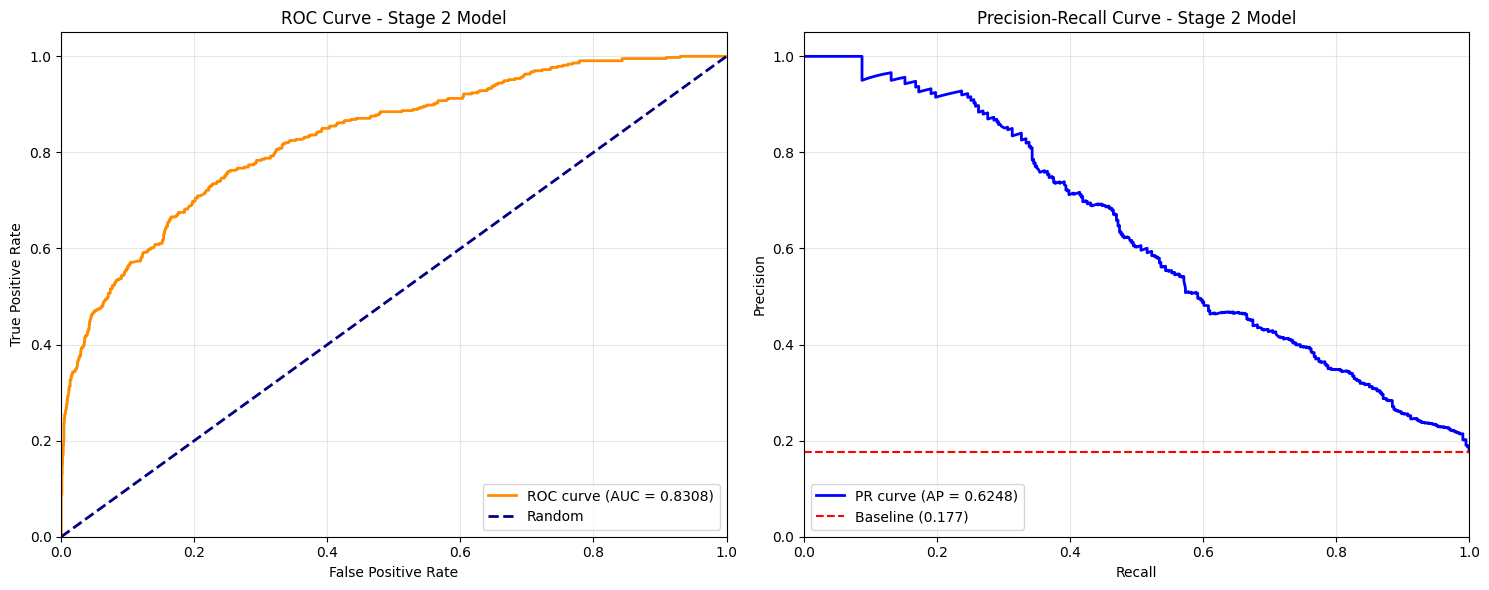


Threshold Optimization Results:
Optimal threshold for F1-score: 0.414 (F1 = 0.5551)
Optimal threshold for Accuracy: 0.717 (Accuracy = 0.8701)
Optimal threshold for Balanced Accuracy: 0.293 (Bal. Acc = 0.7526)

Metrics with optimal F1 threshold (0.414):
Accuracy: 0.8388
Balanced Accuracy: 0.7329
Precision: 0.5417
Recall: 0.5691
F1-Score: 0.5551
Matthews Correlation Coefficient: 0.4569


In [22]:
stage1_model, stage2_model, stage1_features, stage2_features = simple_two_stage_gbm(df)


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, 
    precision_recall_fscore_support, average_precision_score,
    roc_curve, precision_recall_curve, accuracy_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    log_loss, brier_score_loss
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

def simple_two_stage_gbm(df):
    """
    A simpler two-stage approach using Gradient Boosting
    """
    # Define safe features (no SC data)
    safe_features = [
        'electricitybill', 'heatingbill', 'selfipa_done',
        'total_bc_attempts', 'total_bc_outcomes',
        'lead_to_first_bc_days', 'bc_duration_days',
        'positive_outcome_ratio', 'engagement_score',
        'efficiency_score', 'last_bc_outcome_encoded'
    ] + [col for col in df.columns if 'mktg_' in col or 'region_' in col]
    
    safe_features = [f for f in safe_features if f in df.columns]
    
    # Stage 1: Predict if will have meaningful SC interaction
    print("Stage 1: Training SC engagement model...")
    y_stage1 = (df['net_SC'] > 0).astype(int)
    X_stage1 = df[safe_features]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_stage1, y_stage1, test_size=0.2, random_state=42, stratify=y_stage1
    )
    
    # Handle imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Train Stage 1 model
    stage1_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    stage1_model.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate Stage 1 with comprehensive metrics
    stage1_pred = stage1_model.predict_proba(X_test)[:, 1]
    stage1_pred_binary = (stage1_pred >= 0.5).astype(int)
    
    # Stage 1 Metrics
    stage1_auc = roc_auc_score(y_test, stage1_pred)
    stage1_accuracy = accuracy_score(y_test, stage1_pred_binary)
    stage1_balanced_acc = balanced_accuracy_score(y_test, stage1_pred_binary)
    stage1_precision, stage1_recall, stage1_f1, _ = precision_recall_fscore_support(y_test, stage1_pred_binary, average='binary')
    stage1_mcc = matthews_corrcoef(y_test, stage1_pred_binary)
    stage1_kappa = cohen_kappa_score(y_test, stage1_pred_binary)
    stage1_avg_precision = average_precision_score(y_test, stage1_pred)
    stage1_log_loss = log_loss(y_test, stage1_pred)
    stage1_brier_score = brier_score_loss(y_test, stage1_pred)
    
    print(f"Stage 1 Comprehensive Metrics:")
    print(f"AUC-ROC: {stage1_auc:.4f}")
    print(f"Accuracy: {stage1_accuracy:.4f}")
    print(f"Balanced Accuracy: {stage1_balanced_acc:.4f}")
    print(f"Precision: {stage1_precision:.4f}")
    print(f"Recall: {stage1_recall:.4f}")
    print(f"F1-Score: {stage1_f1:.4f}")
    print(f"Matthews Correlation Coefficient: {stage1_mcc:.4f}")
    print(f"Cohen's Kappa: {stage1_kappa:.4f}")
    print(f"Average Precision (PR-AUC): {stage1_avg_precision:.4f}")
    print(f"Log Loss: {stage1_log_loss:.4f}")
    print(f"Brier Score: {stage1_brier_score:.4f}")
    
    # Stage 1 Confusion Matrix
    stage1_cm = confusion_matrix(y_test, stage1_pred_binary)
    print(f"\nStage 1 Confusion Matrix:")
    print(f"TN: {stage1_cm[0,0]}, FP: {stage1_cm[0,1]}")
    print(f"FN: {stage1_cm[1,0]}, TP: {stage1_cm[1,1]}")
    
    # Stage 2: Among those with SC, predict contract
    print("\n" + "="*60)
    print("Stage 2: Training contract prediction model...")
    
    # Filter to only those with SC engagement
    df_with_sc = df[df['net_SC'] > 0].copy()
    
    # Now safe to use all features including SC data
    all_features = safe_features + ['gross_SC', 'net_SC', 'gross_FU', 'net_FU']
    all_features = [f for f in all_features if f in df.columns]
    
    X_stage2 = df_with_sc[all_features]
    y_stage2 = df_with_sc['grosscontractsigned']
    
    # Split
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_stage2, y_stage2, test_size=0.2, random_state=42, stratify=y_stage2
    )
    
    # Balance if needed
    if y_train2.sum() < len(y_train2) * 0.3:  # If less than 30% positive
        X_train2, y_train2 = smote.fit_resample(X_train2, y_train2)
    
    # Train Stage 2 model
    stage2_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    stage2_model.fit(X_train2, y_train2)
    
    # Evaluate Stage 2 with comprehensive metrics
    stage2_pred = stage2_model.predict_proba(X_test2)[:, 1]
    
    # Convert probabilities to binary predictions (using 0.5 threshold)
    stage2_pred_binary = (stage2_pred >= 0.5).astype(int)

    # Calculate comprehensive metrics for Stage 2
    stage2_auc = roc_auc_score(y_test2, stage2_pred)
    stage2_accuracy = accuracy_score(y_test2, stage2_pred_binary)
    stage2_balanced_acc = balanced_accuracy_score(y_test2, stage2_pred_binary)
    precision, recall, f1, support = precision_recall_fscore_support(y_test2, stage2_pred_binary, average='binary')
    stage2_mcc = matthews_corrcoef(y_test2, stage2_pred_binary)
    stage2_kappa = cohen_kappa_score(y_test2, stage2_pred_binary)
    avg_precision = average_precision_score(y_test2, stage2_pred)
    stage2_log_loss = log_loss(y_test2, stage2_pred)
    stage2_brier_score = brier_score_loss(y_test2, stage2_pred)

    # Print comprehensive metrics
    print(f"Stage 2 Comprehensive Metrics:")
    print(f"AUC-ROC: {stage2_auc:.4f}")
    print(f"Accuracy: {stage2_accuracy:.4f}")
    print(f"Balanced Accuracy: {stage2_balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {stage2_mcc:.4f}")
    print(f"Cohen's Kappa: {stage2_kappa:.4f}")
    print(f"Average Precision (PR-AUC): {avg_precision:.4f}")
    print(f"Log Loss: {stage2_log_loss:.4f}")
    print(f"Brier Score: {stage2_brier_score:.4f}")

    # Calculate per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_test2, stage2_pred_binary, average=None
    )
    
    print(f"\nPer-Class Metrics:")
    print(f"Class 0 (No Contract) - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1: {f1_per_class[0]:.4f}, Support: {support_per_class[0]}")
    print(f"Class 1 (Contract) - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1: {f1_per_class[1]:.4f}, Support: {support_per_class[1]}")

    # Macro and Weighted averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_test2, stage2_pred_binary, average='macro'
    )
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_test2, stage2_pred_binary, average='weighted'
    )
    
    print(f"\nMacro Averages:")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    
    print(f"\nWeighted Averages:")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test2, stage2_pred_binary))

    # Confusion Matrix
    cm = confusion_matrix(y_test2, stage2_pred_binary)
    print(f"\nStage 2 Confusion Matrix:")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
    
    # Calculate additional confusion matrix derived metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Same as recall
    negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\nAdditional Confusion Matrix Metrics:")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Sensitivity (True Positive Rate/Recall): {sensitivity:.4f}")
    print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")

    # Plot ROC Curve and PR Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test2, stage2_pred)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {stage2_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve - Stage 2 Model')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test2, stage2_pred)
    ax2.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
    ax2.axhline(y=np.mean(y_test2), color='red', linestyle='--', label=f'Baseline ({np.mean(y_test2):.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve - Stage 2 Model')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Optional: Find optimal threshold based on F1-score
    f1_scores = []
    accuracies = []
    balanced_accuracies = []
    thresholds = np.linspace(0, 1, 100)

    for threshold in thresholds:
        pred_binary = (stage2_pred >= threshold).astype(int)
        _, _, f1_temp, _ = precision_recall_fscore_support(y_test2, pred_binary, average='binary', zero_division=0)
        acc_temp = accuracy_score(y_test2, pred_binary)
        bal_acc_temp = balanced_accuracy_score(y_test2, pred_binary)
        
        f1_scores.append(f1_temp)
        accuracies.append(acc_temp)
        balanced_accuracies.append(bal_acc_temp)

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)
    optimal_threshold_acc = thresholds[np.argmax(accuracies)]
    optimal_acc = max(accuracies)
    optimal_threshold_bal_acc = thresholds[np.argmax(balanced_accuracies)]
    optimal_bal_acc = max(balanced_accuracies)

    print(f"\nThreshold Optimization Results:")
    print(f"Optimal threshold for F1-score: {optimal_threshold:.3f} (F1 = {optimal_f1:.4f})")
    print(f"Optimal threshold for Accuracy: {optimal_threshold_acc:.3f} (Accuracy = {optimal_acc:.4f})")
    print(f"Optimal threshold for Balanced Accuracy: {optimal_threshold_bal_acc:.3f} (Bal. Acc = {optimal_bal_acc:.4f})")

    # Metrics with optimal F1 threshold
    optimal_pred_binary = (stage2_pred >= optimal_threshold).astype(int)
    opt_precision, opt_recall, opt_f1, _ = precision_recall_fscore_support(y_test2, optimal_pred_binary, average='binary')
    opt_accuracy = accuracy_score(y_test2, optimal_pred_binary)
    opt_balanced_acc = balanced_accuracy_score(y_test2, optimal_pred_binary)
    opt_mcc = matthews_corrcoef(y_test2, optimal_pred_binary)

    print(f"\nMetrics with optimal F1 threshold ({optimal_threshold:.3f}):")
    print(f"Accuracy: {opt_accuracy:.4f}")
    print(f"Balanced Accuracy: {opt_balanced_acc:.4f}")
    print(f"Precision: {opt_precision:.4f}")
    print(f"Recall: {opt_recall:.4f}")
    print(f"F1-Score: {opt_f1:.4f}")
    print(f"Matthews Correlation Coefficient: {opt_mcc:.4f}")
    
    # Return models and metrics for potential further use
    return {
        'stage1_model': stage1_model,
        'stage2_model': stage2_model,
        'stage1_metrics': {
            'auc': stage1_auc,
            'accuracy': stage1_accuracy,
            'balanced_accuracy': stage1_balanced_acc,
            'precision': stage1_precision,
            'recall': stage1_recall,
            'f1': stage1_f1,
            'mcc': stage1_mcc,
            'kappa': stage1_kappa
        },
        'stage2_metrics': {
            'auc': stage2_auc,
            'accuracy': stage2_accuracy,
            'balanced_accuracy': stage2_balanced_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': stage2_mcc,
            'kappa': stage2_kappa,
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1
        }
    }